<a href="https://colab.research.google.com/github/chenyenchu/Deep_learning/blob/main/JPY(Timeseries_Forecast)_DNN_Demo_for_class_2023_Student_ver(Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

import tensorflow as tf
# Functions for evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# Note: Some metrics need to be defined manually

In [114]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE

# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator

    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
#load data(sometimes need to use "/")
df = pd.read_csv('/content/drive/MyDrive/JPY=X.csv')
# Colab
#df = pd.read_csv('')
df

,Year,Month,Day,Y
0,2017,5,31,110.838997
1,2017,6,1,110.795998
2,2017,6,2,111.436996
3,2017,6,5,110.462997
4,2017,6,6,110.380997
...,...,...,...,...
1543,2023,5,25,139.283005
1544,2023,5,26,140.016998
1545,2023,5,29,140.871002
1546,2023,5,30,140.440994


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [117]:
# 1.1 Convert date
df['Date']=pd.to_datetime(df.iloc[:,[0,1,2]])
# df['Date']=pd.to_datetime
df

,Year,Month,Day,Y,Date
0,2017,5,31,110.838997,2017-05-31
1,2017,6,1,110.795998,2017-06-01
2,2017,6,2,111.436996,2017-06-02
3,2017,6,5,110.462997,2017-06-05
4,2017,6,6,110.380997,2017-06-06
...,...,...,...,...,...
1543,2023,5,25,139.283005,2023-05-25
1544,2023,5,26,140.016998,2023-05-26
1545,2023,5,29,140.871002,2023-05-29
1546,2023,5,30,140.440994,2023-05-30


In [118]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548 entries, 0 to 1547
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Year    1548 non-null   int64         
 1   Month   1548 non-null   int64         
 2   Day     1548 non-null   int64         
 3   Y       1548 non-null   float64       
 4   Date    1548 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 60.6 KB


In [119]:
new_df=df.iloc[:,[4,3]].copy()
new_df.head()

,Date,Y
0,2017-05-31,110.838997
1,2017-06-01,110.795998
2,2017-06-02,111.436996
3,2017-06-05,110.462997
4,2017-06-06,110.380997


In [120]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df.describe()

,Y
count,1548.000000
mean,114.716413
std,10.861656
min,102.678001
25%,108.364498
50%,110.480499
75%,114.118748
max,150.175995


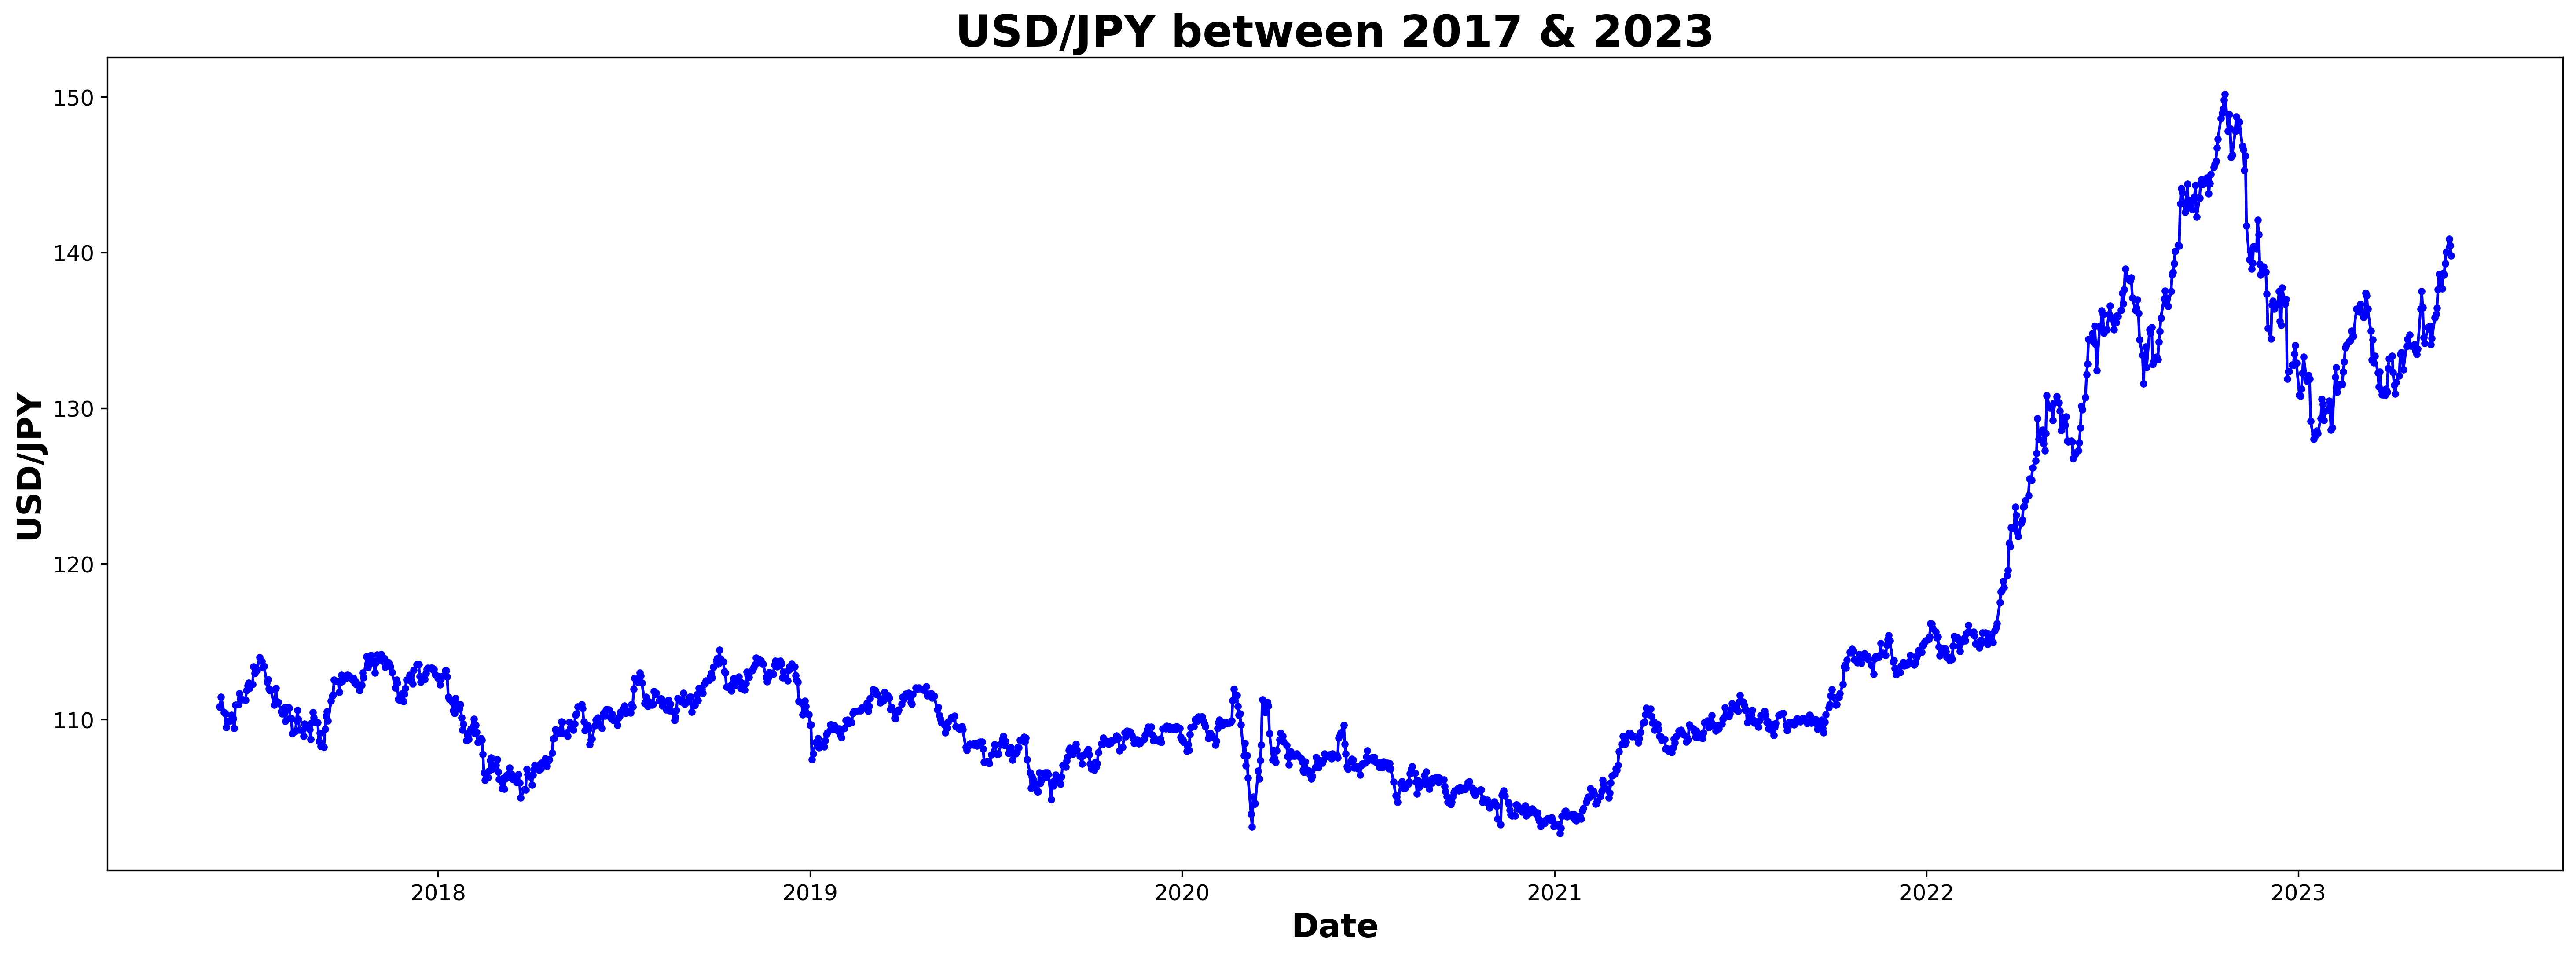

In [121]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('USD/JPY between 2017 & 2023',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('USD/JPY',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Y'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [122]:
# Create 3 lags
new_df['Lag_1']=new_df['Y'].shift(1).copy()
new_df['Lag_2']=new_df['Y'].shift(2).copy()
new_df['Lag_3']=new_df['Y'].shift(3).copy()
new_df.head()

,Date,Y,Lag_1,Lag_2,Lag_3
0,2017-05-31,110.838997,NaN,NaN,NaN
1,2017-06-01,110.795998,110.838997,NaN,NaN
2,2017-06-02,111.436996,110.795998,110.838997,NaN
3,2017-06-05,110.462997,111.436996,110.795998,110.838997
4,2017-06-06,110.380997,110.462997,111.436996,110.795998


In [123]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Y,Lag_1,Lag_2,Lag_3
0,2017-06-05,110.462997,111.436996,110.795998,110.838997
1,2017-06-06,110.380997,110.462997,111.436996,110.795998
2,2017-06-07,109.509003,110.380997,110.462997,111.436996
3,2017-06-08,109.900002,109.509003,110.380997,110.462997
4,2017-06-09,109.859001,109.900002,109.509003,110.380997
...,...,...,...,...,...
1540,2023-05-25,139.283005,138.598007,138.671997,137.692001
1541,2023-05-26,140.016998,139.283005,138.598007,138.671997
1542,2023-05-29,140.871002,140.016998,139.283005,138.598007
1543,2023-05-30,140.440994,140.871002,140.016998,139.283005


In [ ]:
# Export the data
#clean_df.to_csv('D:/data_analysis/PyExport/Rainfall_Lags.csv',index=False, header=True)
# Colab
#clean_df.to_csv('Rainfall_Lags.csv',index=False, header=True)

# 3. Data preprocessing under time-series structure

A total of 21 years are in the data set. In this practice, we will use the last three years of data as the testing set

In [124]:
# Train data
Forecast_train_data=clean_df.iloc[0:1459,:].copy()
Forecast_train_data

,Date,Y,Lag_1,Lag_2,Lag_3
0,2017-06-05,110.462997,111.436996,110.795998,110.838997
1,2017-06-06,110.380997,110.462997,111.436996,110.795998
2,2017-06-07,109.509003,110.380997,110.462997,111.436996
3,2017-06-08,109.900002,109.509003,110.380997,110.462997
4,2017-06-09,109.859001,109.900002,109.509003,110.380997
...,...,...,...,...,...
1454,2023-01-25,130.238998,130.597000,129.354004,128.369995
1455,2023-01-26,129.237000,130.238998,130.597000,129.354004
1456,2023-01-27,129.800003,129.237000,130.238998,130.597000
1457,2023-01-30,129.854004,129.800003,129.237000,130.238998


In [125]:
# Test data
Forecast_test_data=clean_df.iloc[1459:1459+86,:].copy()
Forecast_test_data

,Date,Y,Lag_1,Lag_2,Lag_3
1459,2023-02-01,130.110001,130.479004,129.854004,129.800003
1460,2023-02-02,128.621994,130.110001,130.479004,129.854004
1461,2023-02-03,128.746002,128.621994,130.110001,130.479004
1462,2023-02-06,132.009003,128.746002,128.621994,130.110001
1463,2023-02-07,132.623001,132.009003,128.746002,128.621994
...,...,...,...,...,...
1540,2023-05-25,139.283005,138.598007,138.671997,137.692001
1541,2023-05-26,140.016998,139.283005,138.598007,138.671997
1542,2023-05-29,140.871002,140.016998,139.283005,138.598007
1543,2023-05-30,140.440994,140.871002,140.016998,139.283005


# 4. Prepare time-series data for train/validation structure manually

Here we have a total of 18 years of data in training data set that are ready to be further splitted into training and validation data set

18 years of data can be evenlly divided into 6 portions (3 years in each portion)

# Expanding window

In [126]:
# Expanding 1
Exp_training_1=Forecast_train_data.iloc[0:1201,:].copy()
Exp_val_1=Forecast_train_data.iloc[1201:1201+86,:].copy()

# Expanding 2
Exp_training_2=Forecast_train_data.iloc[0:1287,:].copy()
Exp_val_2=Forecast_train_data.iloc[1287:1287+86,:].copy()

# Expanding 3
Exp_training_3=Forecast_train_data.iloc[0:1373,:].copy()
Exp_val_3=Forecast_train_data.iloc[1373:1373+86,:].copy()

# Rolling window

In [127]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:1201,:].copy()
Rol_val_1=Forecast_train_data.iloc[1201:1201+86,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[83:1287,:].copy()
Rol_val_2=Forecast_train_data.iloc[1287:1287+86,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[169:1373,:].copy()
Rol_val_3=Forecast_train_data.iloc[1373:1373+86,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X)

In [128]:
#set x (make prediction)
# Train
x_train=Exp_training_3.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_3.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_3['Y'].copy()
y_val=Exp_val_3['Y'].copy()

In [129]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Y'].copy()
y_val=Rol_val_1['Y'].copy()

# 6. Creating Net

In [130]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.649007,0.601511,0.604697
1,0.576837,0.649007,0.601511
2,0.570761,0.576837,0.649007
3,0.506150,0.570761,0.576837
4,0.535121,0.506150,0.570761


In [131]:
# Tips: Using shape to call the amount of features in the data set
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [132]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.

# Sequential style coding for creating net

In [133]:
# Some self define functions for building deep neural networks
def dense_generator(model_name,layers,last_layer_neurons,activation_fun='relu'):
    n=last_layer_neurons
    neurons=n
    for i in range(0,layers):
        neurons=neurons*2
        model_name.add(Dense(units=neurons, activation=activation_fun))

In [203]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='softmax'))

# 6.3 Add 5 dense layers
dense_generator(model,5,6)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2))

# 6.5 Add 2 more dense layers
dense_generator(model,2,192)

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.002,beta_1=0.8)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 96)                4704      
                                                                 
 dense_5 (Dense)             (None, 192)               18624     
                                                                 
 dropout (Dropout)           (None, 192)               0

Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [204]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=100, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/100
19/19 [==============================] - 1s 16ms/step - loss: 68.3433 - mean_absolute_percentage_error: 62.4682 - val_loss: 2.9847 - val_mean_absolute_percentage_error: 2.4718
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 5.8042 - mean_absolute_percentage_error: 5.3027 - val_loss: 14.1839 - val_mean_absolute_percentage_error: 11.5982
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 5.0605 - mean_absolute_percentage_error: 4.6268 - val_loss: 16.4014 - val_mean_absolute_percentage_error: 13.3903
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 5.3014 - mean_absolute_percentage_error: 4.8437 - val_loss: 20.9200 - val_mean_absolute_percentage_error: 17.0698
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 5.6346 - mean_absolute_percentage_error: 5.1495 - val_loss: 17.1122 - val_mean_absolute_percentage_error: 13.9497
Epoch 6/100
19/19 [==============================] - 0s 7ms/step

In [205]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

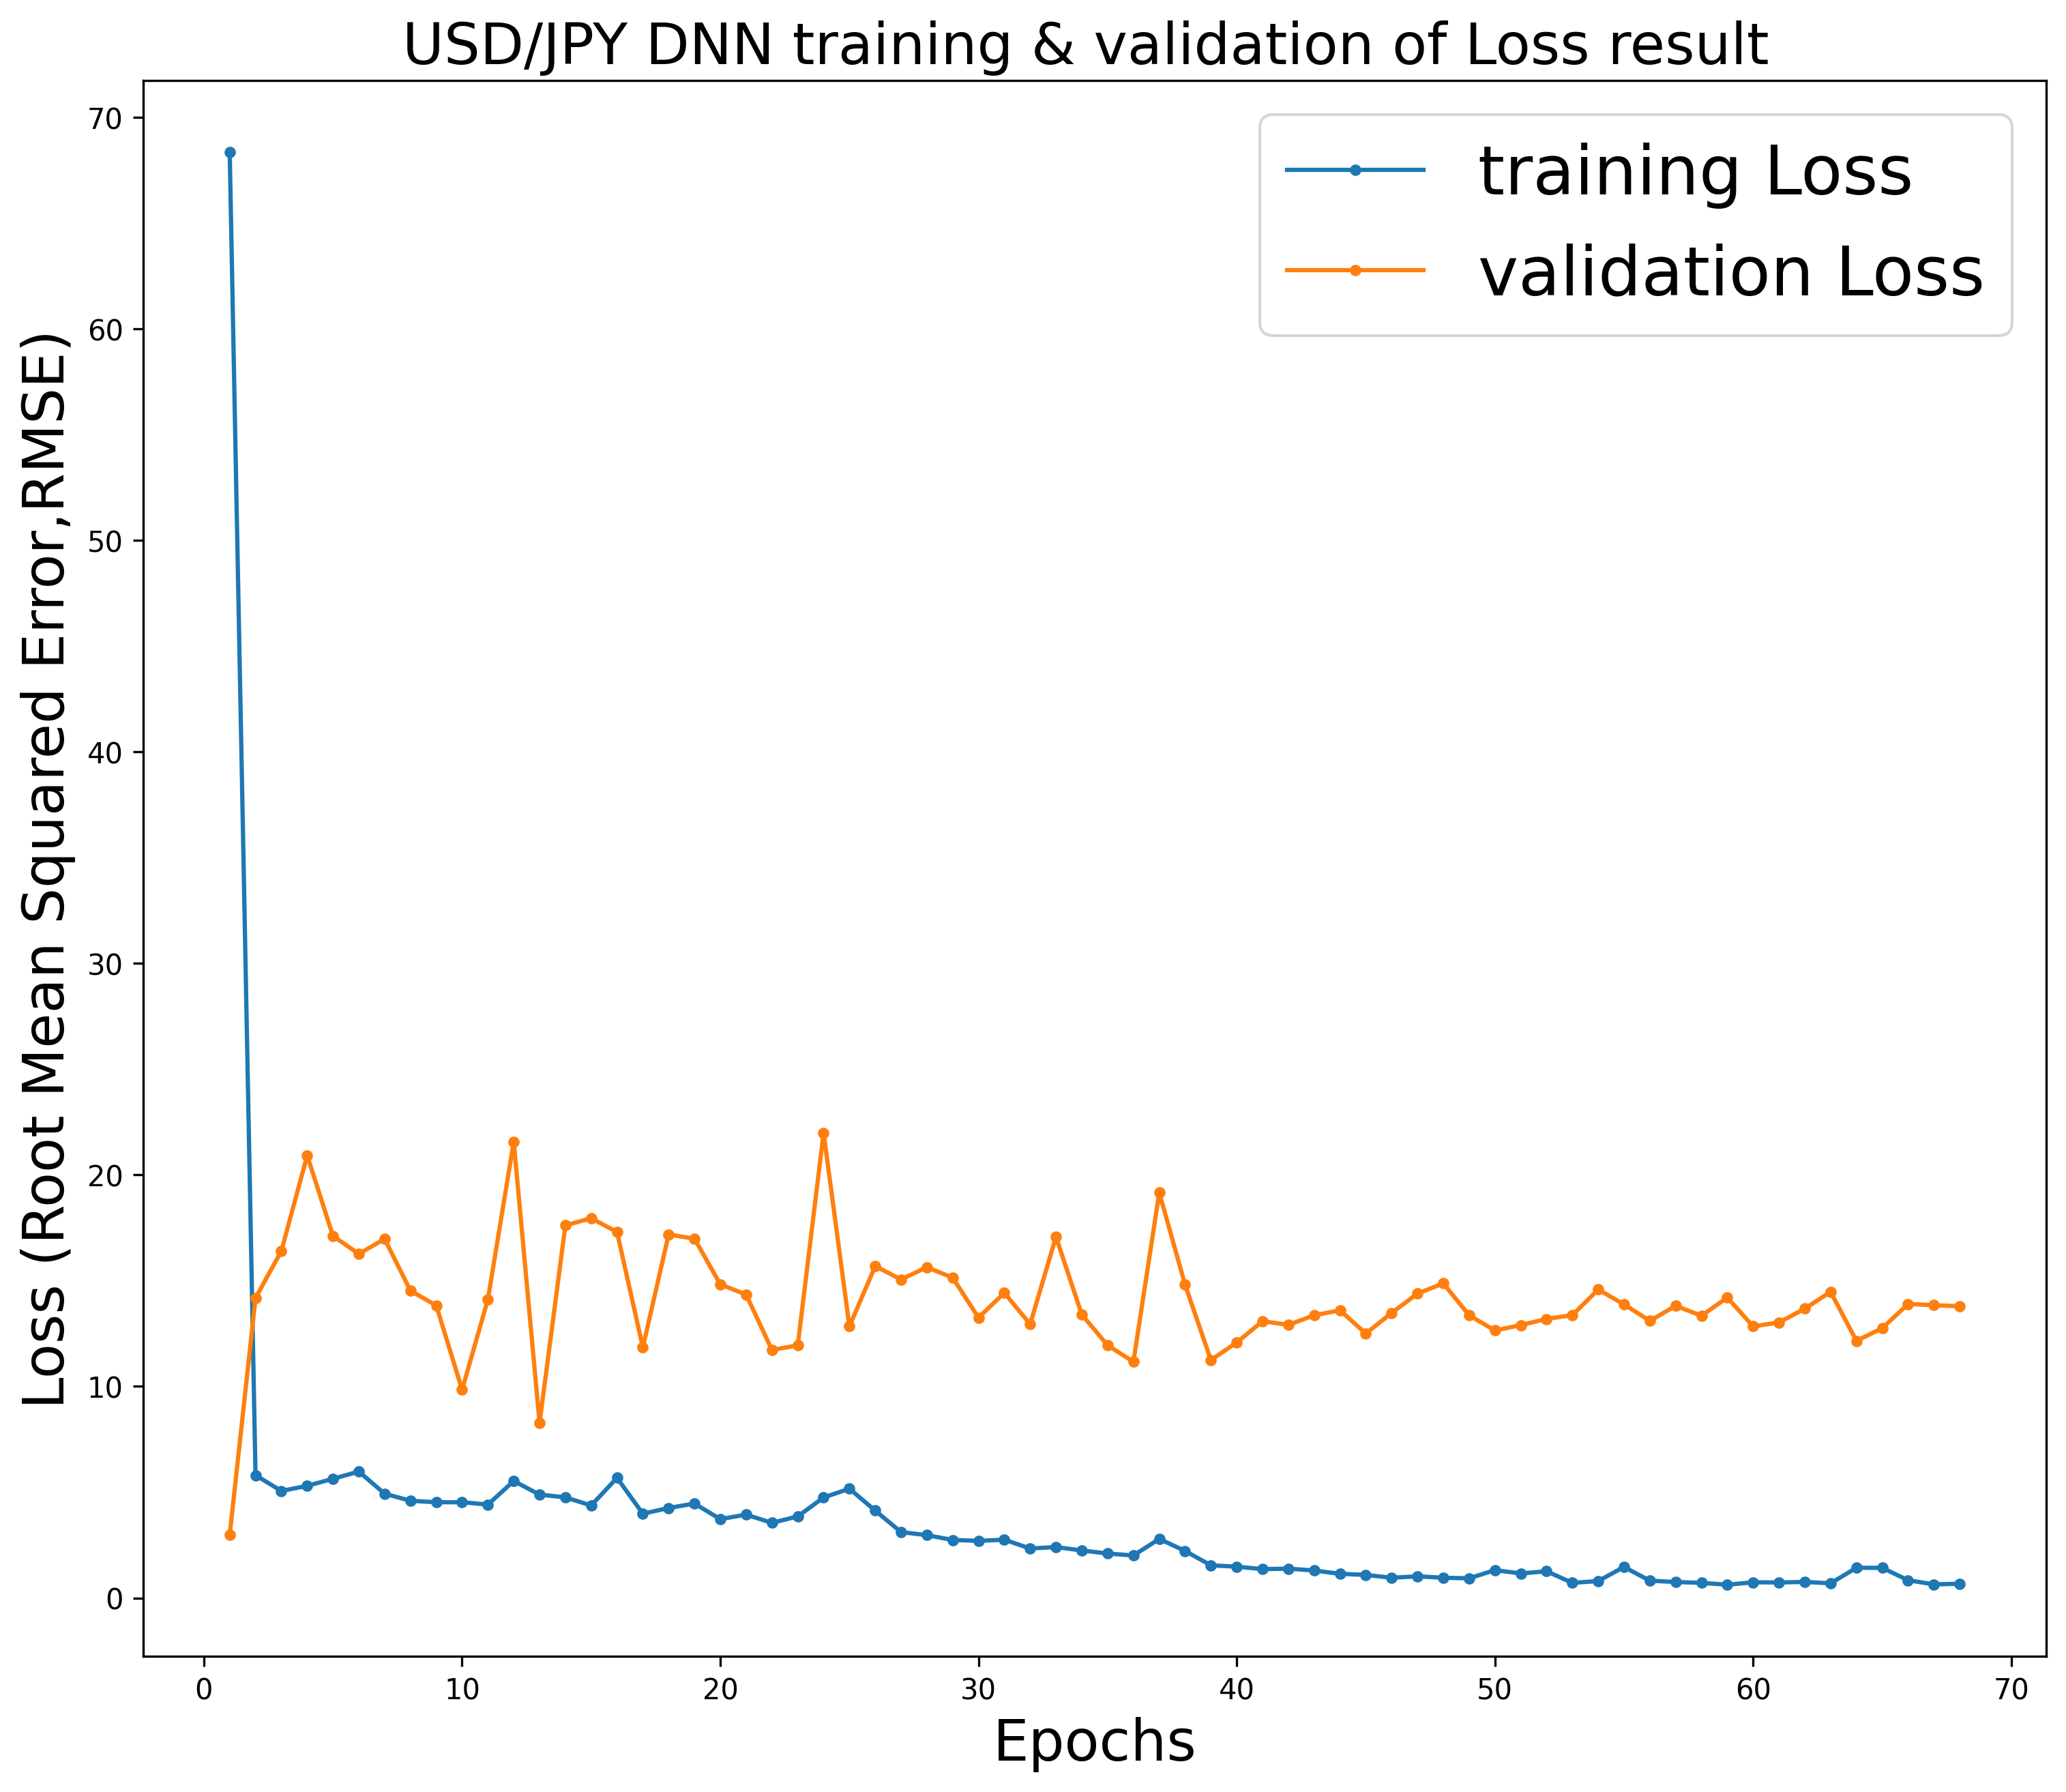

In [206]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('USD/JPY DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

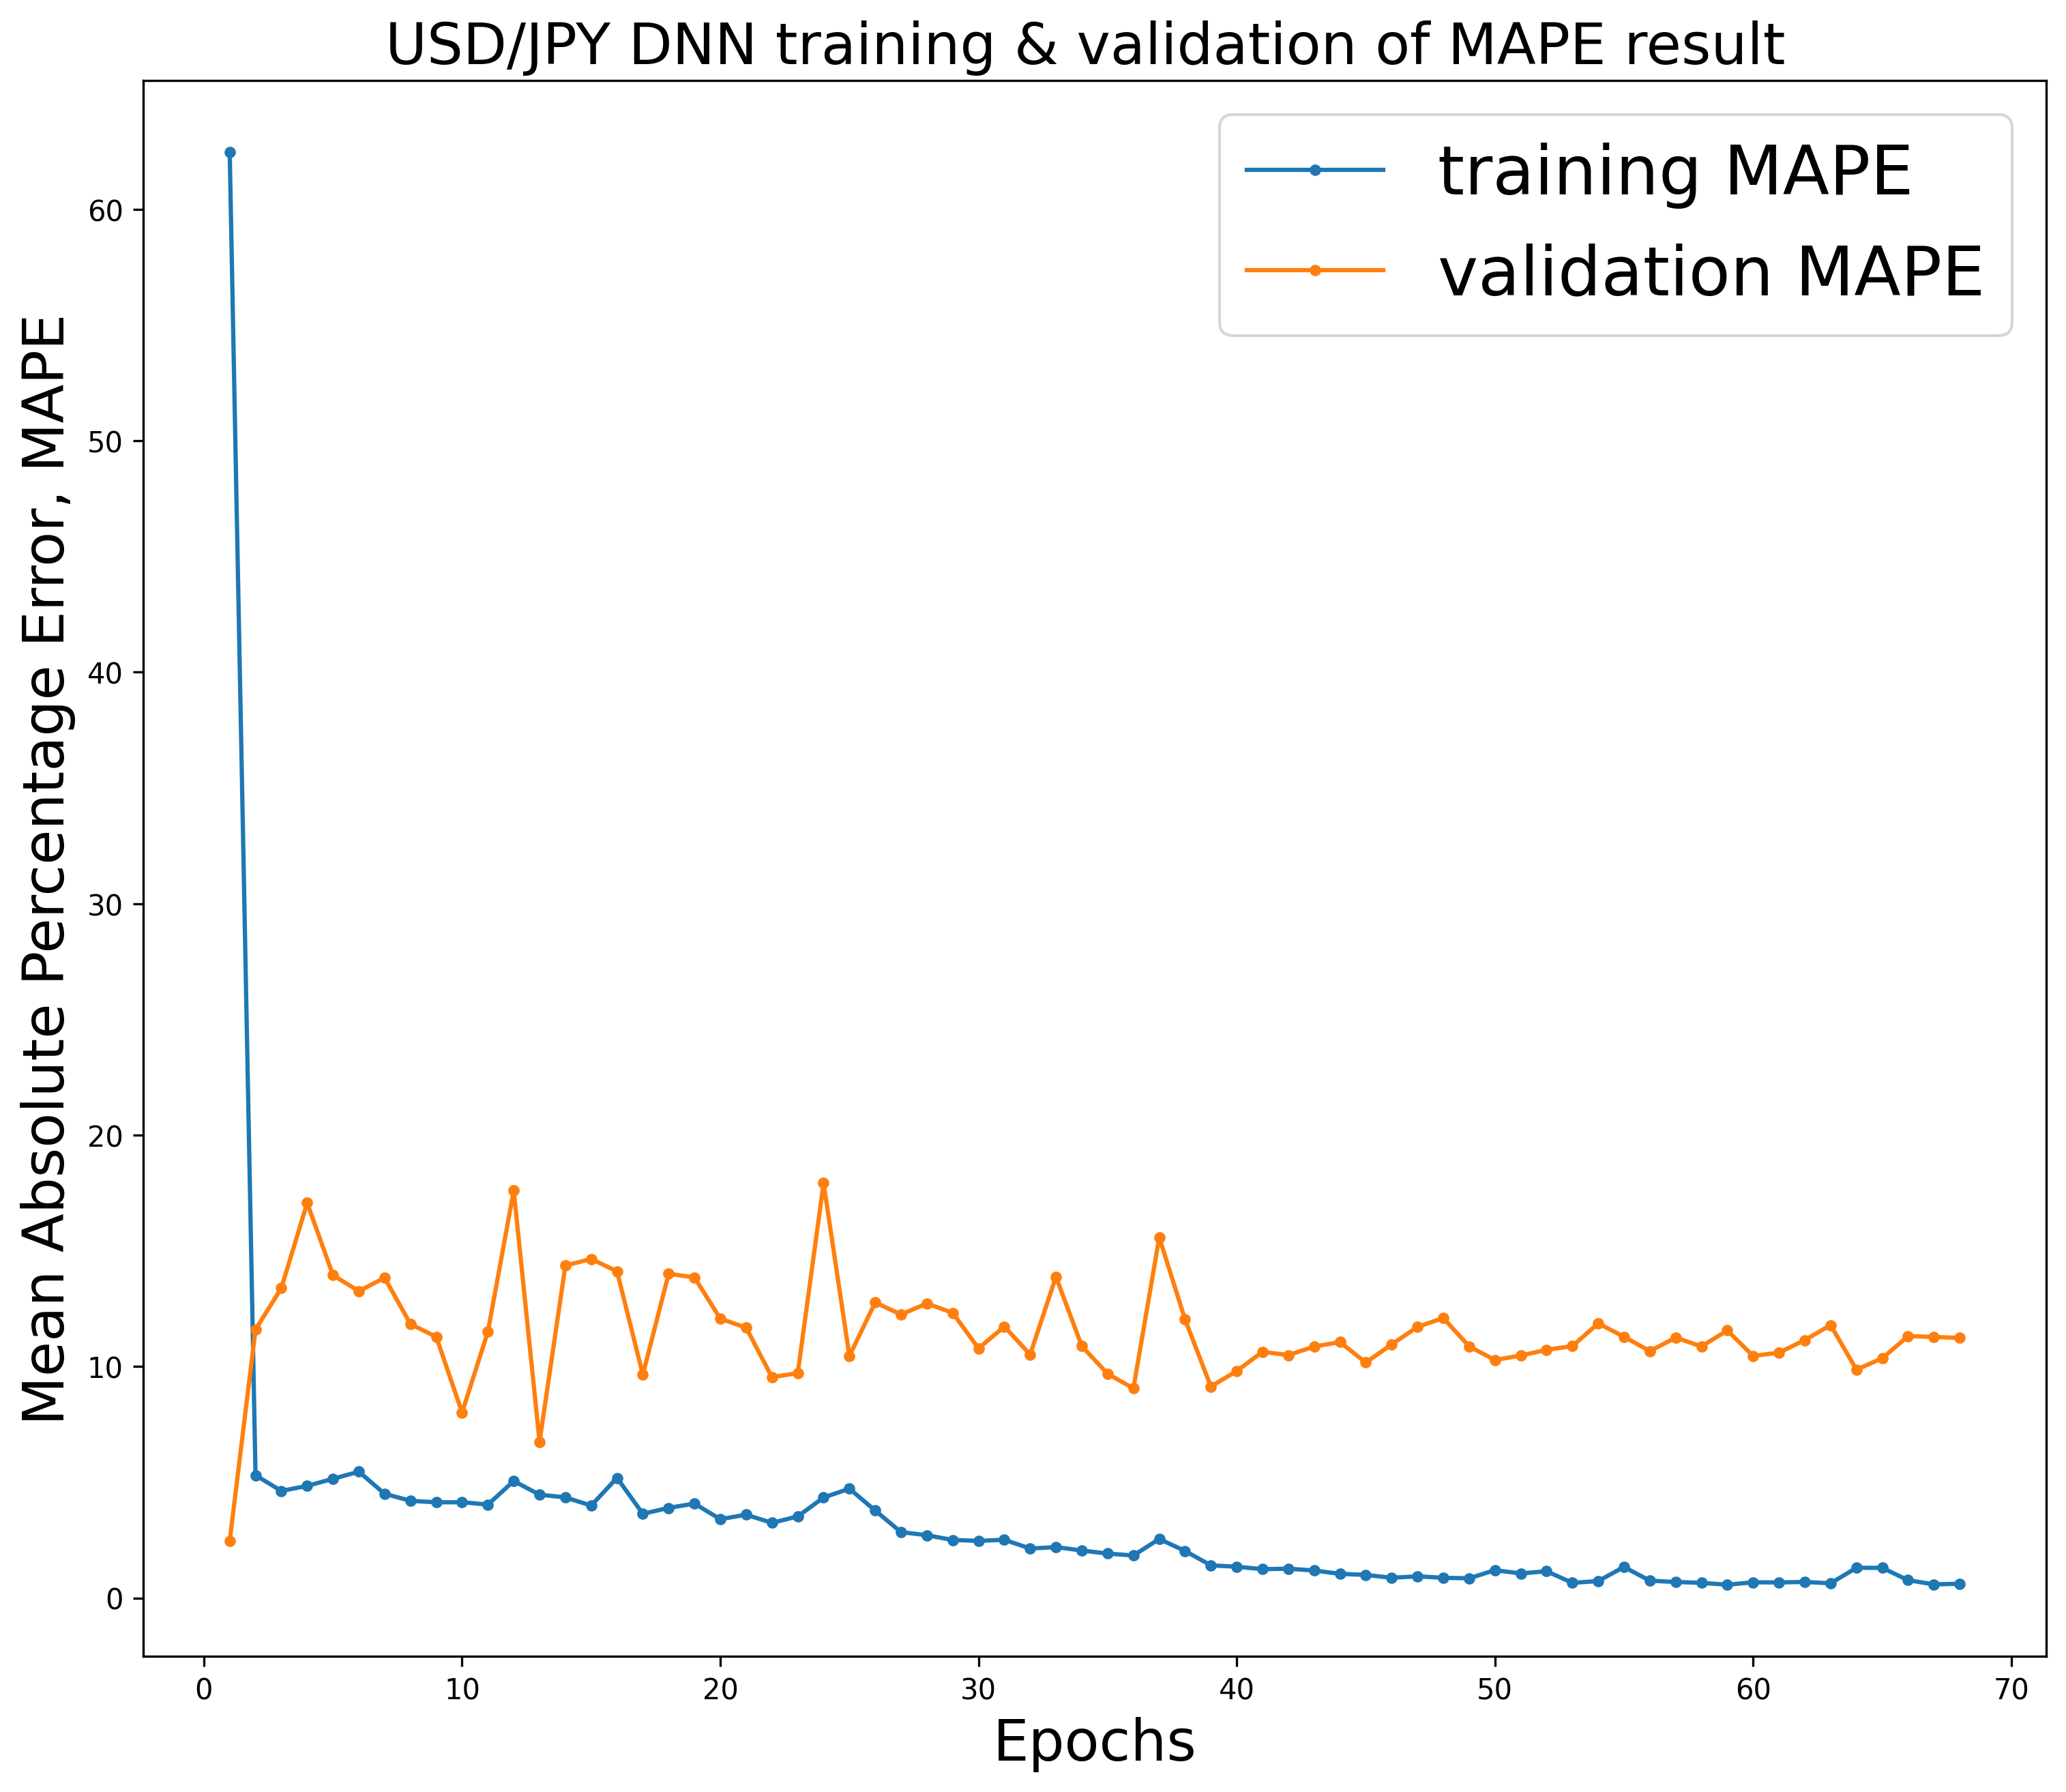

In [207]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('USD/JPY DNN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [208]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Y'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Y'].copy()

In [209]:
# Some self define functions for building deep neural networks
def dense_generator(model_name,layers,last_layer_neurons,activation_fun='relu'):
    n=last_layer_neurons
    neurons=n
    for i in range(0,layers):
        neurons=neurons*2
        model_name.add(Dense(units=neurons, activation=activation_fun))

In [210]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='softmax'))

# 6.3 Add 5 dense layers
dense_generator(Fmodel,5,6)

# 6.4 Add dropout layer
Fmodel.add(Dropout(rate=0.2))

# 6.5 Add 2 more dense layers
dense_generator(Fmodel,2,192)

# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.002,beta_1=0.8)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 96)                4704      
                                                                 
 dense_5 (Dense)             (None, 192)               18624     
                                                                 
 dropout (Dropout)           (None, 192)               0

In [211]:
# Store in the history for more useful information
# 以這個為基準，做testing
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=100, batch_size=64,verbose=1)

Epoch 1/100
23/23 [==============================] - 1s 7ms/step - loss: 58.2837 - mean_absolute_percentage_error: 51.3766
Epoch 2/100
23/23 [==============================] - 0s 9ms/step - loss: 9.4687 - mean_absolute_percentage_error: 7.9439
Epoch 3/100
23/23 [==============================] - 0s 8ms/step - loss: 8.8784 - mean_absolute_percentage_error: 7.4516
Epoch 4/100
23/23 [==============================] - 0s 7ms/step - loss: 9.3864 - mean_absolute_percentage_error: 7.8995
Epoch 5/100
23/23 [==============================] - 0s 8ms/step - loss: 9.5322 - mean_absolute_percentage_error: 8.0181
Epoch 6/100
23/23 [==============================] - 0s 7ms/step - loss: 8.6274 - mean_absolute_percentage_error: 7.2126
Epoch 7/100
23/23 [==============================] - 0s 8ms/step - loss: 8.4362 - mean_absolute_percentage_error: 7.0004
Epoch 8/100
23/23 [==============================] - 0s 7ms/step - loss: 9.3972 - mean_absolute_percentage_error: 7.9118
Epoch 9/100
23/23 [===========

In [212]:
# 7.3 Save the trained models
#Fmodel.save('/content/drive/MyDrive/Rainfall_forecast_ANN_trained_model.h5')
# Colab
Fmodel.save('/content/drive/MyDrive/JPY=X.h5')
print('Model has been saved...')

Model has been saved...


In [213]:
# 7.4 Restore the saved model for testing
ANN_model=keras.models.load_model('/content/drive/MyDrive/JPY=X.h5')
# Colab
#ANN_model=keras.models.load_model('')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [214]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Y'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Y'].copy()

In [215]:
# 8.1 Make prediction
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [216]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Y'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
1459,2023-02-01,130.110001,110.839996,19.270005
1460,2023-02-02,128.621994,110.839996,17.781998
1461,2023-02-03,128.746002,110.839996,17.906006
1462,2023-02-06,132.009003,110.839996,21.169007
1463,2023-02-07,132.623001,110.839996,21.783005
...,...,...,...,...
1540,2023-05-25,139.283005,110.839996,28.443009
1541,2023-05-26,140.016998,110.839996,29.177002
1542,2023-05-29,140.871002,110.839996,30.031006
1543,2023-05-30,140.440994,110.839996,29.600998


In [217]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 23.491
MSE: 558.575
RMSE: 23.634
MAPE: 17.457 %
SMAPE: 19.143 %
RAE: 11.455
MRAE: 0.13319923498497518
MdRAE: 12.538 bench: 134.331
RSE: 82.658
RRSE: 9.092


#  Plot for comparing true value & predicted value

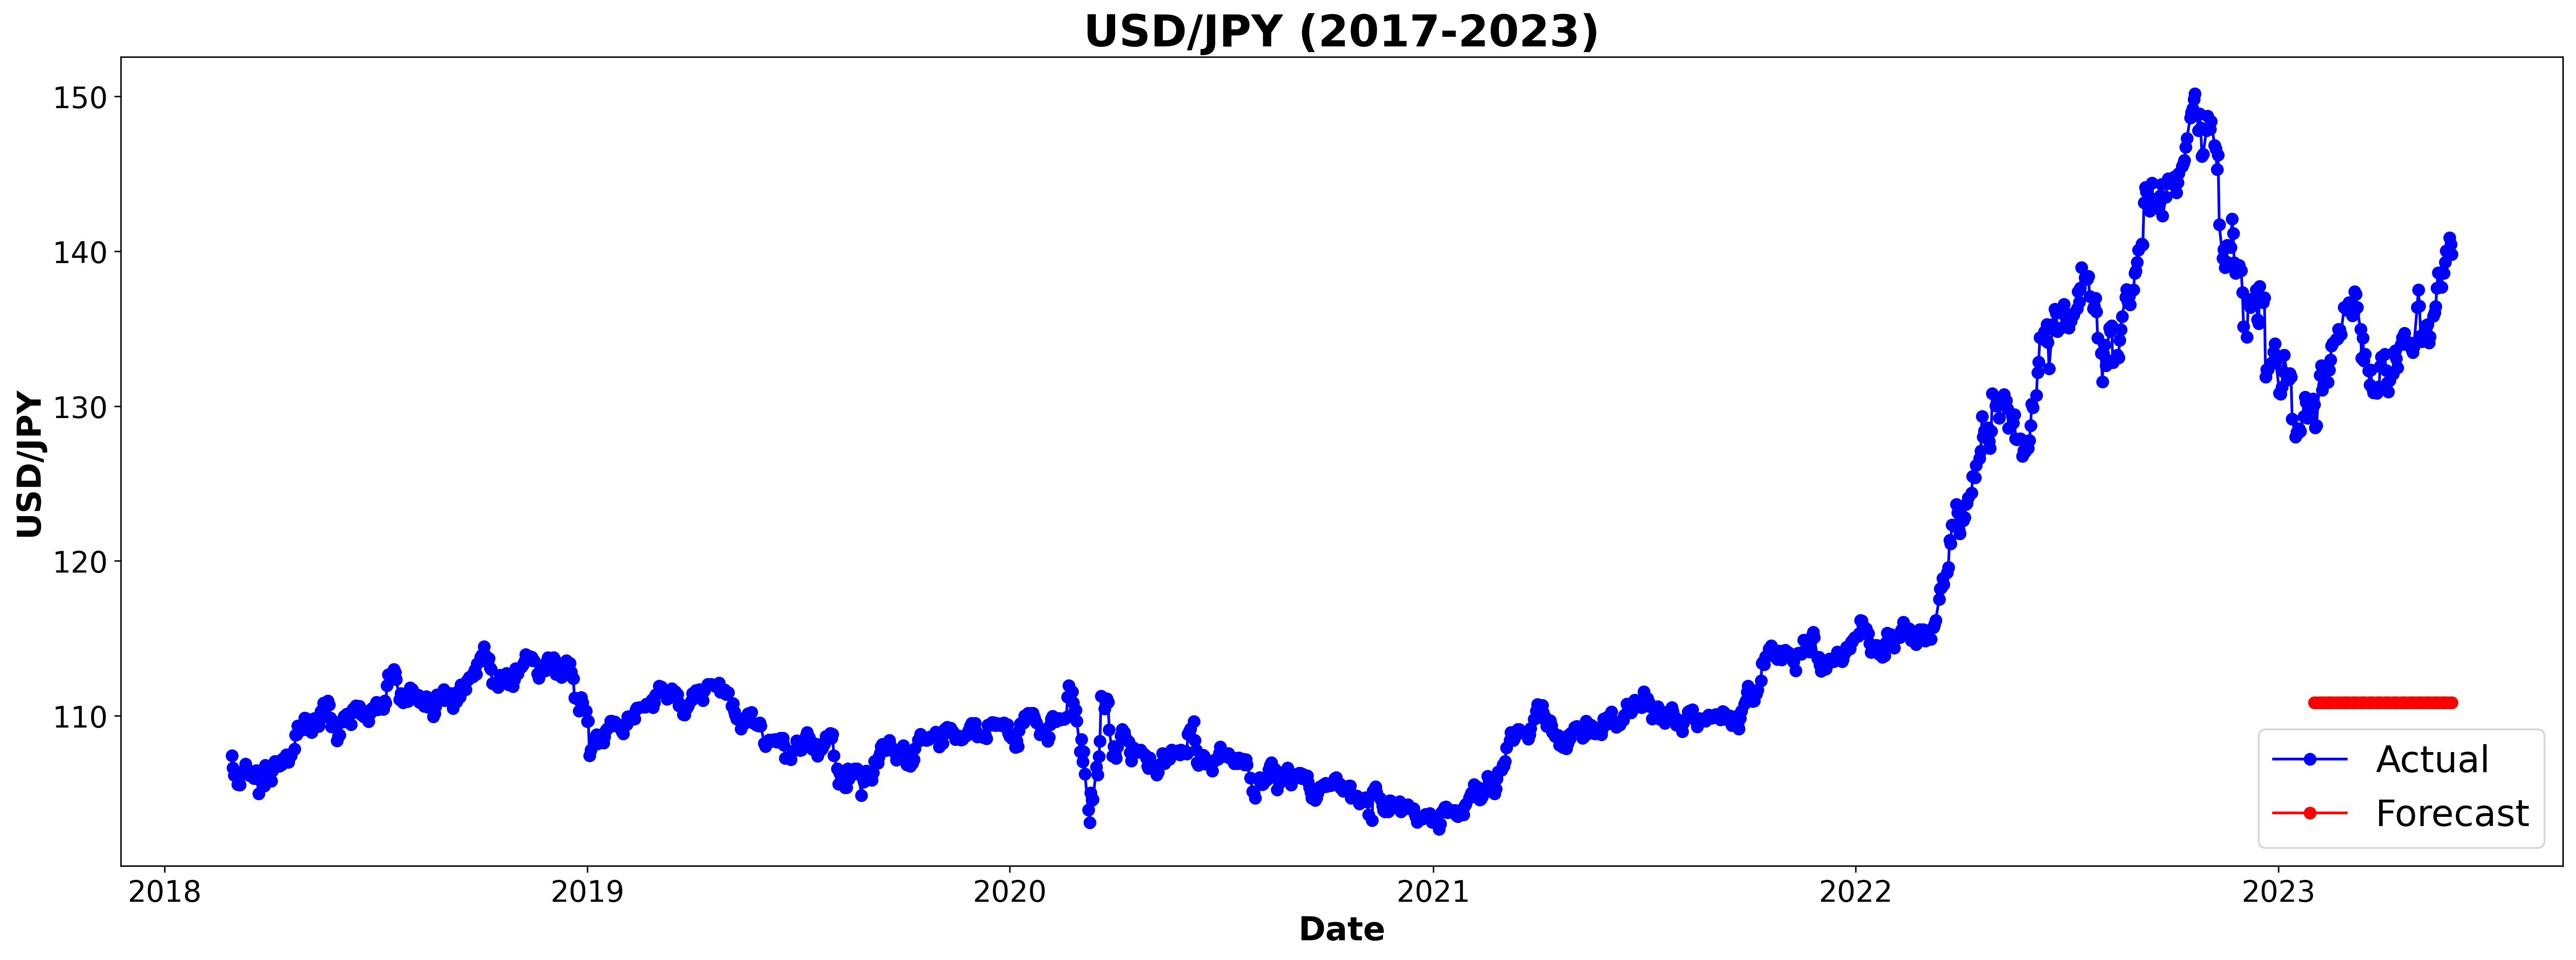

In [218]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('USD/JPY (2017-2023)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('USD/JPY',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[189:,0],clean_df.iloc[189:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

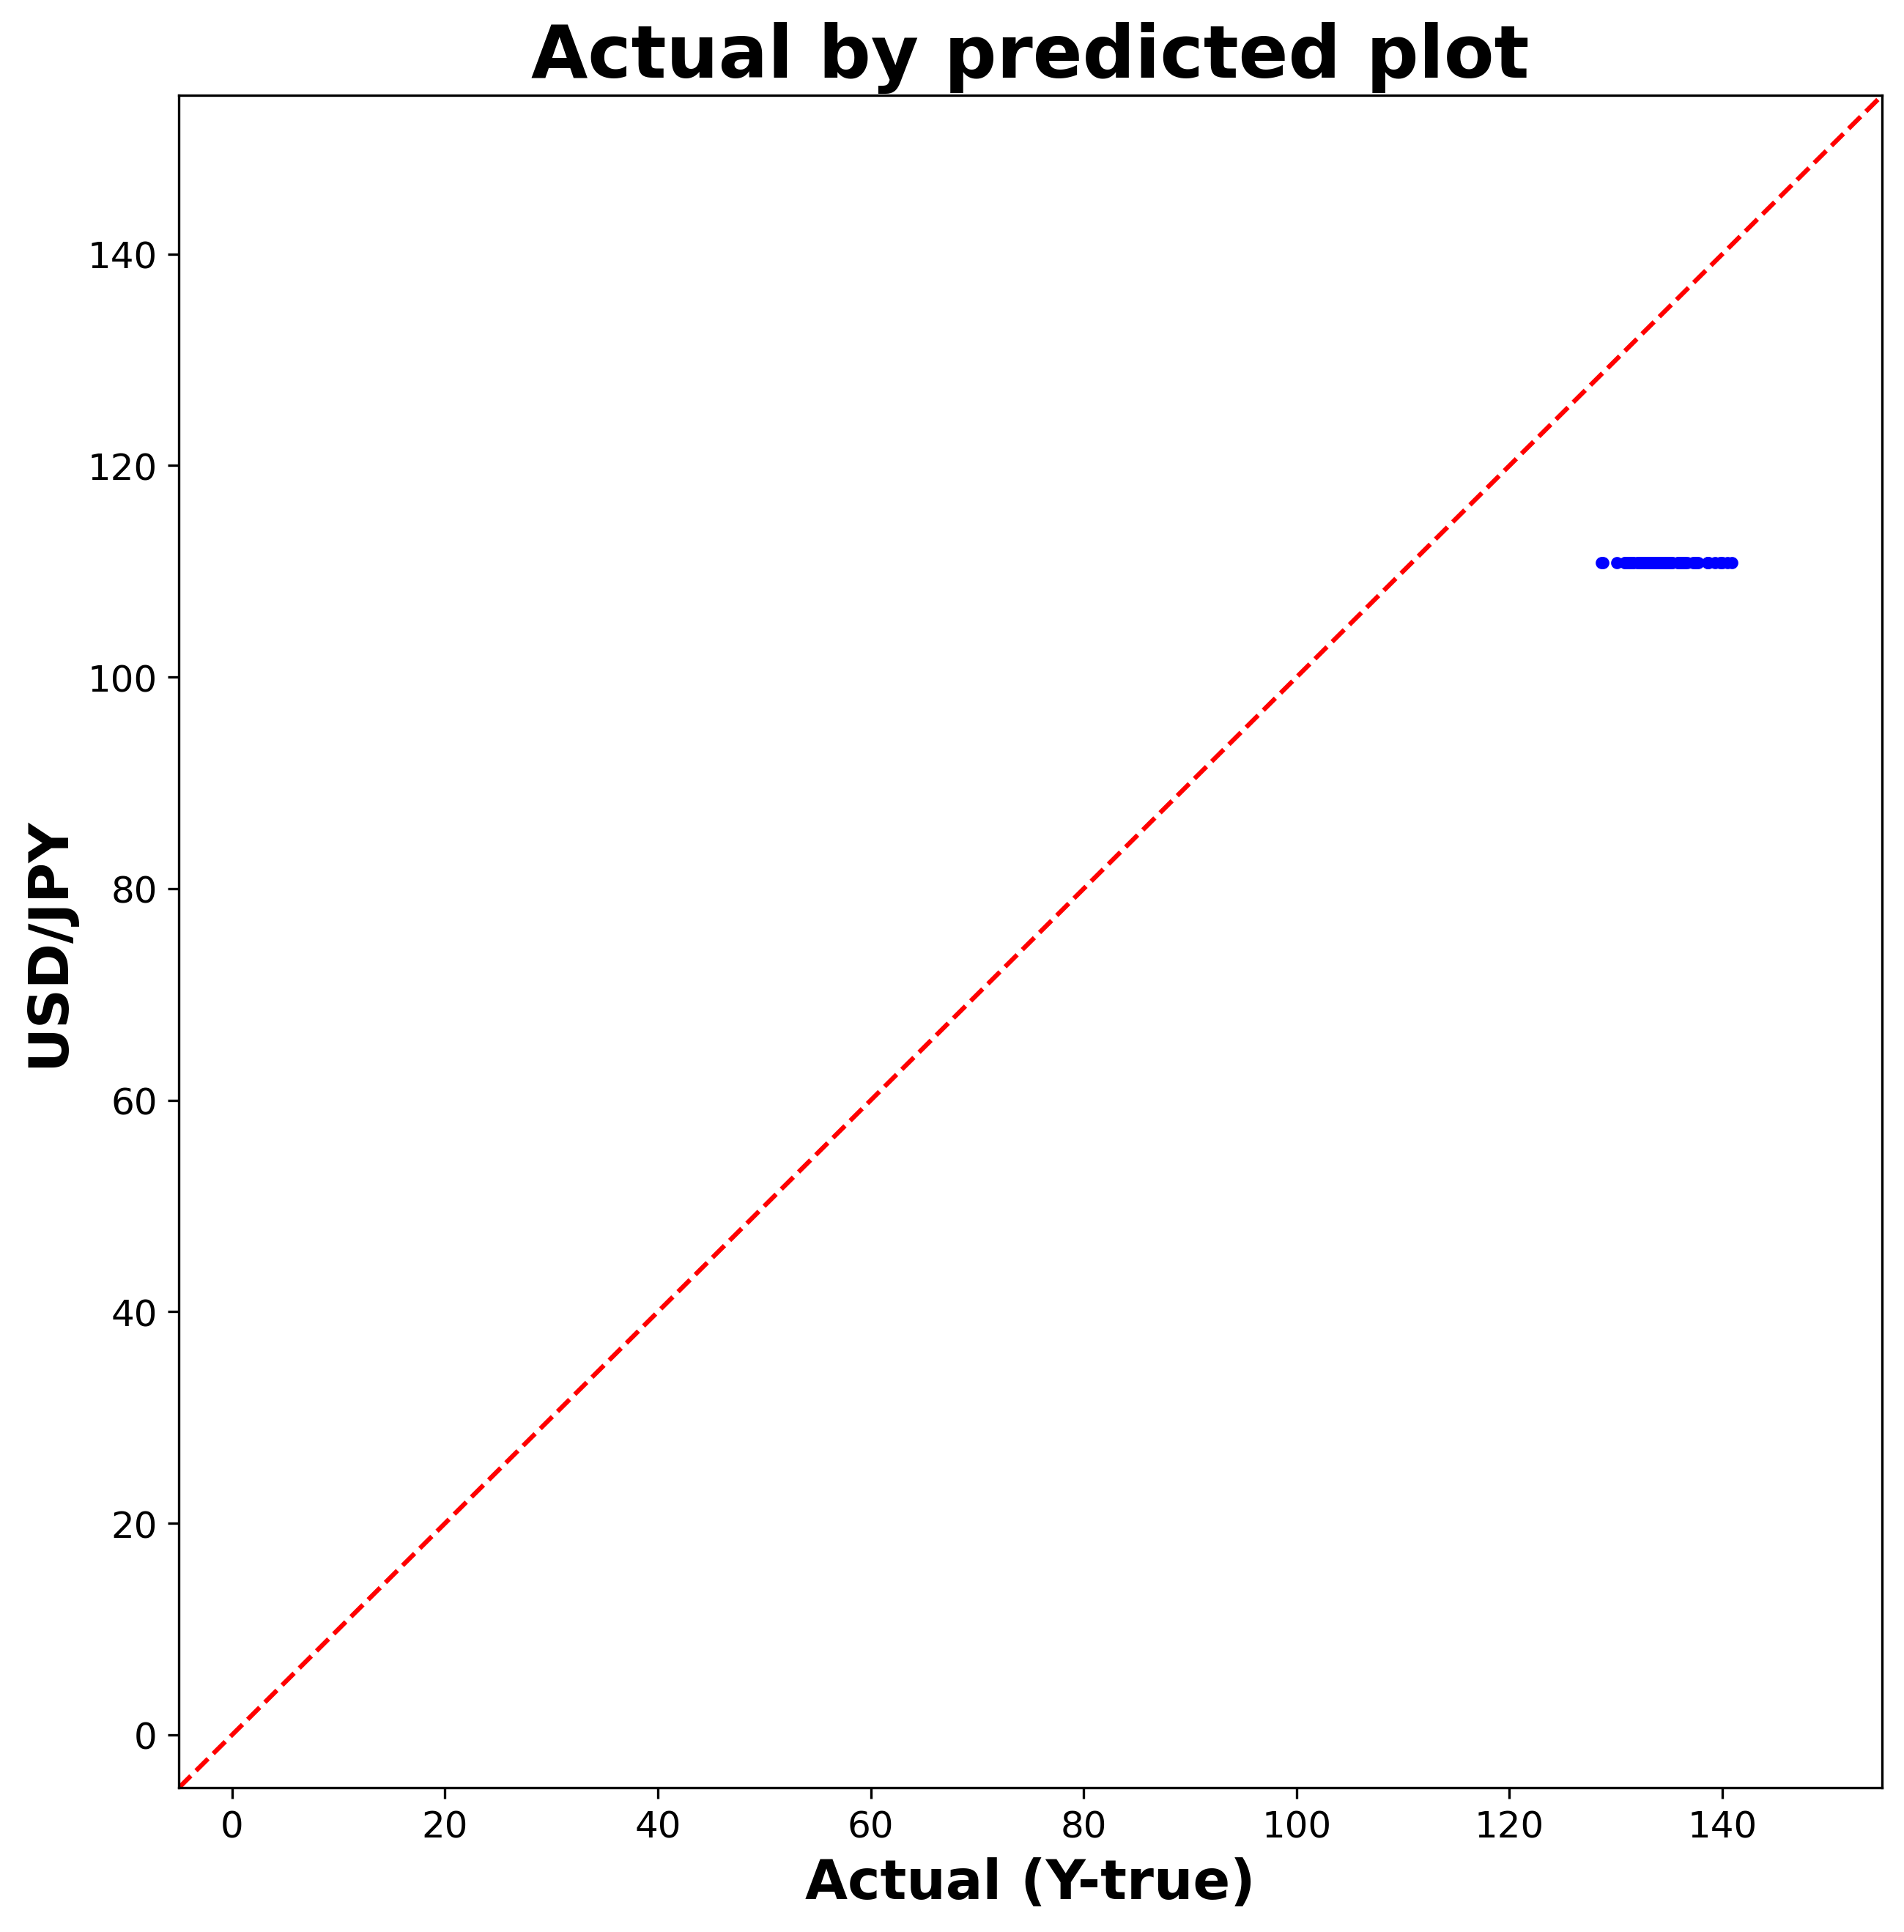

In [219]:
# Lock the scale of axis by Y_true
max_value=150+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('USD/JPY',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()